# Stock Portfolio Dashboard with Dash

This project takes a Thinkorswim data export and turns it into a Dash Dashboard. <br>
The columns in the **monitor > Activity and Positions** table in Thinkorswim need to match the screenshot. There are 3 excel exports included in the repo you can use to run this project. 

## High Level Architecture
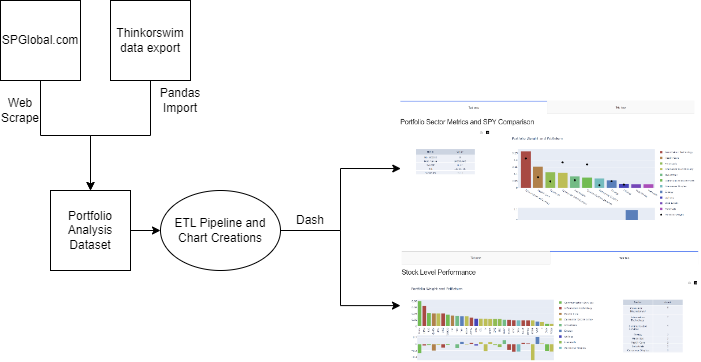

## Thinkorswim export view
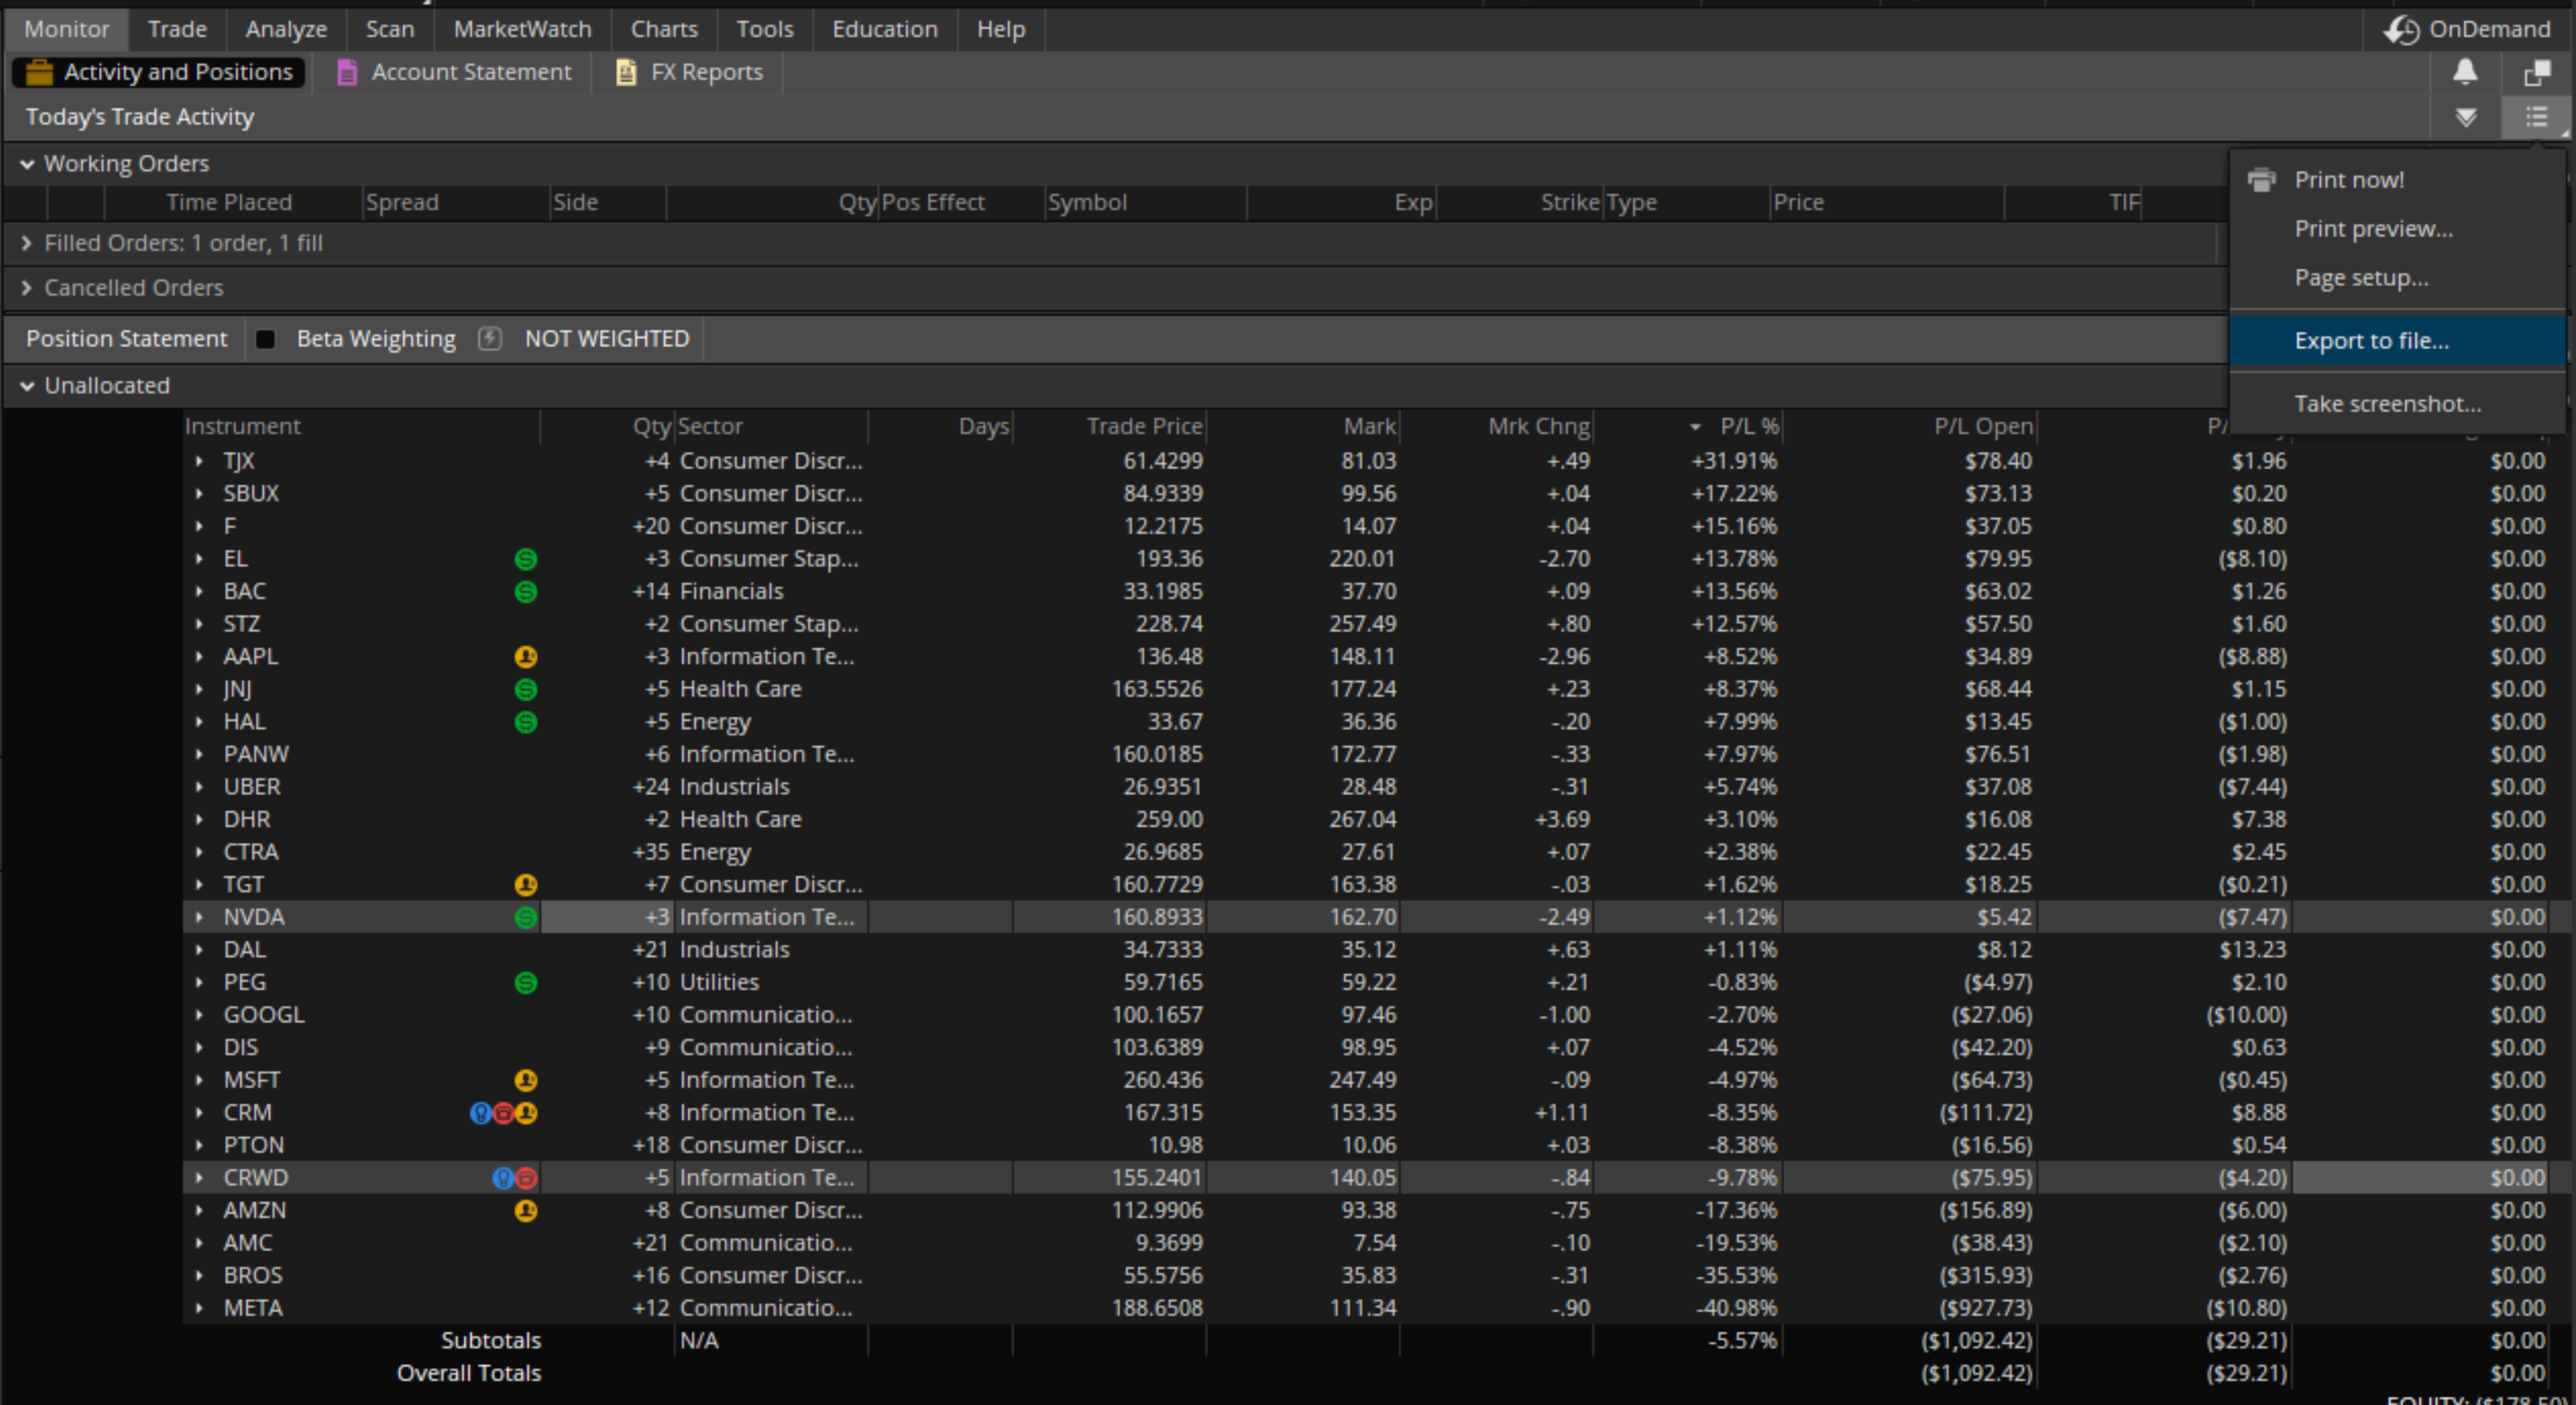

In [137]:
#My regular libraries
import pandas as pd
import re
import numpy as np
import requests, json, re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#Dash libraries
#pip install plotly
#pip install dash
#pip install "jupyterlab>=3" 
#"ipywidgets>=7.6"
import plotly
import dash
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, dash_table

#Scraping Libraries
from bs4 import BeautifulSoup
from selenium import webdriver

#Options
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 30

## Portfolio Metrics

**Note:** Make sure that you update the file name in _#Reading in data and creating relevant variables_ <br>
Here are the building block calculations to create the charts.

**1. pl2str:** This is a data munging function. This takes figures with \$ and \% and turns them into numbers and decimals respectively. <br>
**2. pl:** Portfolio P/L amount <br>
**3. ad:** Non-invested dollars in the portfolio. AKA, cash position. <br>
**4. pv:** Portfolio Value. The dollar value of the entire portfolio (euqities and cash position).  $\sum \limits _{i=1}^{n}  [market price]_{i}[shares]_{i} + ad$ <br>
**5. TV:** Trade Value of stock. _Stock Trade Price_ X _Shares_ <br>
&emsp; a. _Trade Price_ is the price of the stock at time of purchase $ t_{0} $ or average cost basis of the stock for multiple purchase points. <br>
**6. MV:** Market Value of stock. _Stock Market Price_ X _Shares_ <br>
&emsp; a. _Market Price_ is the price of the stock at present time $ t_{n} $. <br>
**7. PW:** Portfolio Weight. $ \frac{MV_{i}}{\sum \limits _{i=1}^{n} MV_{i} + ad} $ <br>
**8. numstocks:** Count of stocks in portfolio. <br>
**9. cashstock:** The percentage cash position. $ \frac{ad}{pv} $ <br>
**10. preturn:** Portfolio return. $ \frac{pl}{pv + |pl| } $ <br>

In [138]:
#Function to transform P/L values to float 
def pl2str(x):
    if len(re.findall('%',str(x))) > 0: return round(float(re.sub('\$|\)|\,|%','',re.sub('\(','-',str(x))))/100,3)
    else: return float(re.sub('\$|\)|\,|%','',re.sub('\(','-',str(x))))

#Reading in data and creating relevant variables
df = pd.read_csv('2022-10-05-PositionStatement.csv',skiprows = 6)

# Filterning down to the relevant stocks
stocks = df.loc[~df.Sector.isnull() == True, df.columns!='Days'].copy().reset_index()

#Column data type transformations
stocks['Trade Price'] = stocks['Trade Price'].astype(float)
stocks['Mark'] = stocks['Mark'].astype(float)
stocks['Qty'] = stocks['Qty'].astype(float)
stocks['P/L Open'] = [pl2str(x) for x in stocks['P/L Open']]
stocks['P/L %'] = [pl2str(x) for x in stocks['P/L %']]

#Taking in the PL, Available Dollars, and Portfolio value
pl = pl2str(df.loc[df.Instrument == 'OVERALL P/L YTD','Qty'].values[0])
ad = pl2str(df.loc[df.Instrument == 'AVAILABLE DOLLARS','Qty'].values[0])
pv = ad + np.array(stocks['Mark'] * stocks['Qty'] ).sum()

#Trade Value (stock worth at time of trade)
stocks['TV'] = stocks['Trade Price'] * stocks['Qty'] 

#Market Value (stock worth at current price )
stocks['MV'] = stocks['Mark'] * stocks['Qty'] 

#Portfolio Weight
stocks['PW'] = stocks['MV']/(stocks['MV'].sum() + ad)

#Calulating number of stocks in the portfolio
numstocks = len(stocks.Instrument.values)
#Calculating cash/stock
cashstock = (ad/pv,1 - ad/pv)
#Calulating portfolio return
preturn = pl/(pv + abs(pl))

## Portfolio Analysis at the Sector Level

The sector analysis involves web scraping SP500 sector weights and comparing that to portfolio sector weights. 

In [139]:
#Defining colors for sectors
colormap = {'Information Technology':'#BF3F3F',
            'Health Care': '#BF7F3F',
            'Consumer Discretionary': '#BFBF3F',
            'Financials': '#7FBF3F',
            'Communication Services':'#3FBF3F',
            'Industrials': '#3FBF7F',
            'Consumer Staples':'#3FBFBF',
            'Energy':'#3F7FBF',
            'Utilities':'#3F3FBF',
            'Real Estate':'#7F3FBF',
            'Materials': '#BF3FBF'
           }

## Scraping SP500 data

**Note:** This was a bit tricky. _BeautifulSoup_ is not enough to get the source data. Javascript needs to run via _webdriver_ to extract the data. 
- Its preferable to run this on Google Chrome
- You need to have the  _slenium webdriver_ installed and the webdriver version **needs to match** your chromedriver. 
- You need to have _chromedriver_. Make sure it matches _webdriver_ version. [Chromedriver](https://chromedriver.chromium.org/downloads).

Additionally, I use regular expressions to scrape. _BeautifulSoup_ and _Selenium_ have functions/methods to scrape more efficiently but I was having trouble figuring that out..

In [140]:
#Function that executes executes a link via webdriver and returns a BeautifulSoup object for web scraping. 
def get_source(url):
    #Make sure you add the Chrome driver to your PATH
    driver = webdriver.Chrome()
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html)
    return soup

#Soup Object
sopa = get_source("https://www.spglobal.com/spdji/en/indices/equity/sp-500/#data")

#Parsing the soup object to extract the sectors and their weights.  
sectors = re.findall('.*\d{1,2}\.\d%',sopa.text)[0].split('%')

#s returns sectors and w weights. The if condition is an ad-hoc fix for an empty string element at the end. 
s = [re.split('\d',x)[0] for x in sectors if len(re.split('\d',x)[0]) > 0  ]
w = [round(float(re.findall('\d{1,2}.*',x)[0])/100,3) for x in sectors if len(re.findall('\d{1,2}.*',x)) > 0 ]

spy = dict(zip(s,w))
spy

{'Information Technology': 0.263,
 'Health Care': 0.153,
 'Financials': 0.114,
 'Consumer Discretionary': 0.109,
 'Industrials': 0.083,
 'Communication Services': 0.075,
 'Consumer Staples': 0.069,
 'Energy': 0.054,
 'Utilities': 0.03,
 'Real Estate': 0.026,
 'Materials': 0.025}

## Individual Graphs and Tables

I created the graphs individually prior to joining for the dashboard.

**Chart 1:** Bar graph of SP500 sector weights <br>
**Chart 2:** Bar graph of portfolio sector weights <br>
**Chart 3:** Bar graph of portfolio - SP500 sector weights <br>
**Chart 4:** Bar graph of SP500 sector weights overlayed with dot graph of portfolio weights <br>
**Chart 5:** Portfolio P/L (returns) by sectors. Building blocks are the following: <br>
&emsp; 1. sectorstv: Sum of TV (trade value) by sector  <br>
&emsp; 2. sectorsmv: Sum of MV (market value) by sector  <br>
&emsp; 3. sectorsdv: sectorstv - sectorsmv  <br>
&emsp; 4. PL: $ \frac{sectorsdv}{sectorsmv + |sectorsdv|} $  <br>
**Chart 6:** Bar graph of portfolio stock weights <br>
**Chart 7:** Portfolio P/L (returns) by stocks.  $ \frac{MV_{i} - TV_{i}}{TV_{i}} $ <br>
**Table 1:** Table with summary statistics: <br>
&emsp; 1. Number of stocks <br>
&emsp; 2. Portfolio Value (pv)<br>
&emsp; 3. Cash position (%) <br>
&emsp; 4. Profit/Loss <br>
&emsp; 5. Return (%)  <br>
**Table 2:** Count of stocks in portfolio by sectors <br>

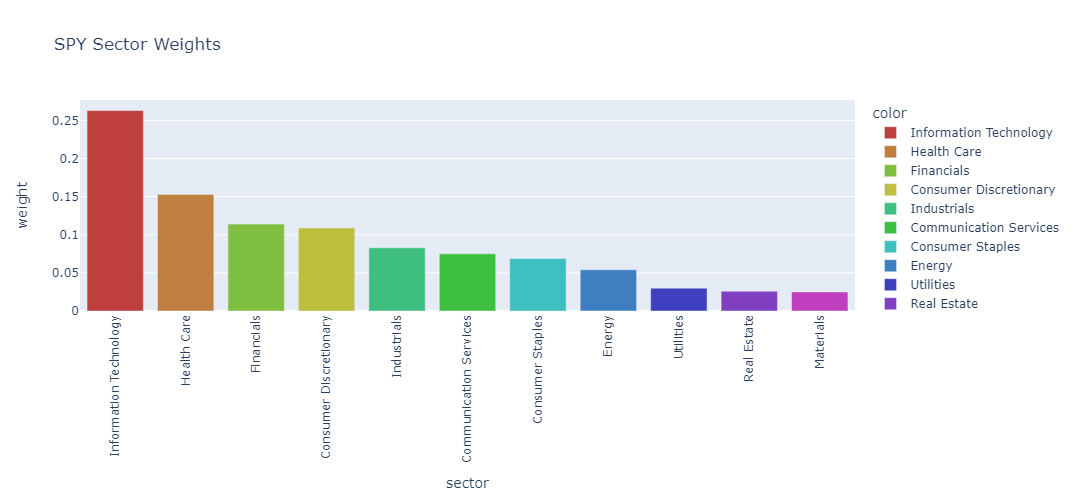

In [141]:
#Chart1 

#Turning the spy dictionary into a dataframe
spy2 = pd.DataFrame(spy.items(), columns = ['sector','weight']).set_index('sector')

#Creating a bar graph of SP500 Sectors 
chart1 = px.bar(spy2, x = spy2.index, y = 'weight', color =[x for x in spy2.index],
                color_discrete_map=colormap,
               title='SPY Sector Weights',
                height = 500)

#Tweaking the tick angles
chart1.update_xaxes(tickangle = -90)

chart1.show()

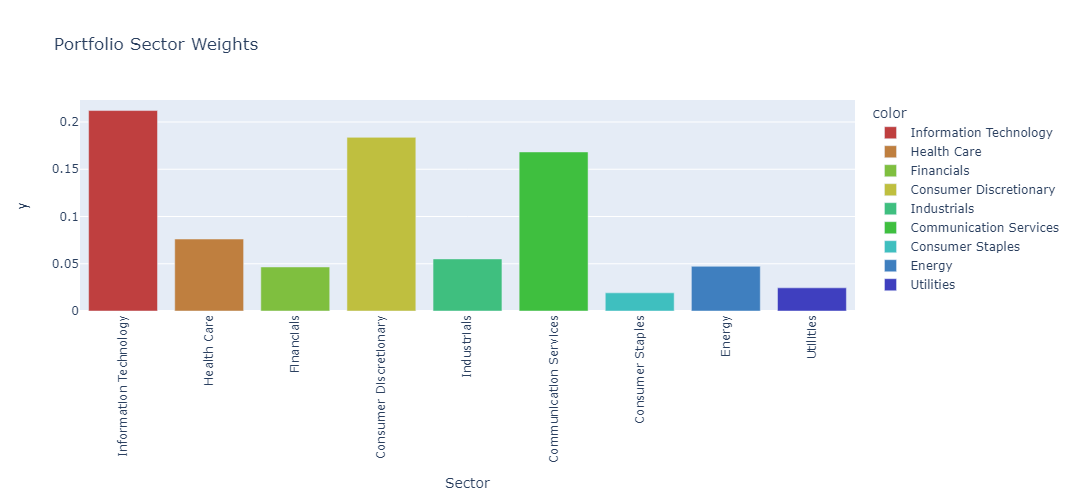

In [142]:
#Chart2

#Aggregating the stocks dataset by sectors and summing the weight returns. Indexes the result to the same order as the SP500 sectors. 
sectors  = stocks.groupby('Sector')
my_sectors = sectors.PW.sum()[[x for x in spy2.index if x in sectors.PW.sum().index]]

#Creating a bar graph of the profolio sector weights
chart2 = px.bar(my_sectors, x = my_sectors.index, y = my_sectors.values, color =[x for x in my_sectors.index],
                color_discrete_map=colormap,
               title='Portfolio Sector Weights',
                height = 500)

#Tweaking the tick angles
chart2.update_xaxes(tickangle = -90)

chart2.show()

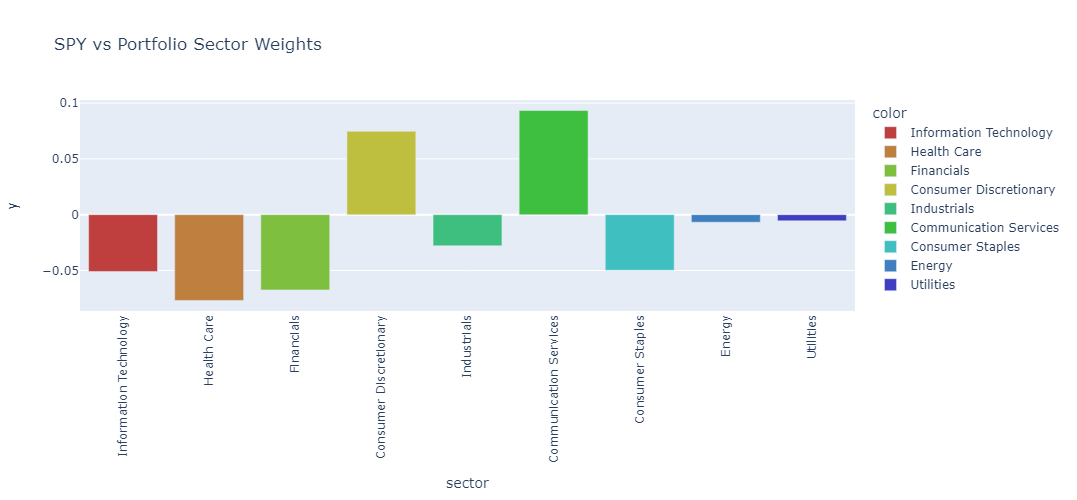

In [143]:
#Chart3

#Joining the SP500 sector dataframe with the portfolio weights. Taking the difference of Portfolio Weight - SP500 sector weight.
#Index to match the order of the SP500 sector weigts. 
spyVp = spy2.join(pd.DataFrame(sectors.PW.sum()),how = 'left')
spyVp['DeltaWeight'] = spyVp['PW'] - spyVp['weight'] 
sector_delta = spyVp['DeltaWeight'][[x for x in spy2.index if x in sectors.PW.sum().index]]

#Creating a bar graph of the difference between the portflio and SP500 sector weights
chart3 = px.bar(sector_delta, x = sector_delta.index, y = sector_delta.values, color =[x for x in sector_delta.index],
                color_discrete_map=colormap,
               title='SPY vs Portfolio Sector Weights',
                height = 500)

#Tweaking the tick angles
chart3.update_xaxes(tickangle = -90)

chart3.show()

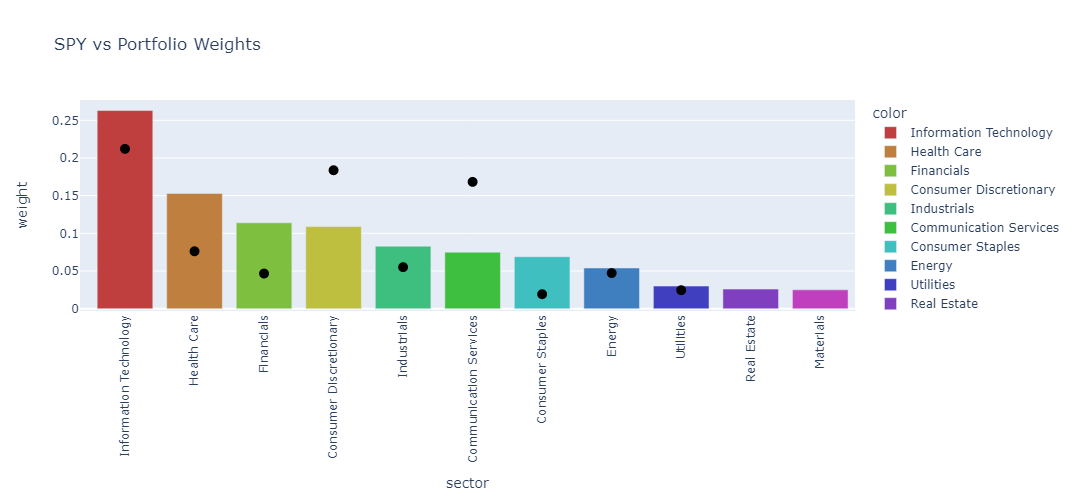

In [144]:
#Chart4

#Creating a bar graph with the SP500 sector weights (identical to chart1)
chart4 = px.bar(spy2, x = spy2.index, y = 'weight', color =[x for x in spy2.index],
                color_discrete_map=colormap,
               title='SPY vs Portfolio Weights',
                height = 500)

#Overlaying the bar graph with a dot plot of  portfolio weights. This enables comparison. 
chart4.add_scatter(x = my_sectors.index, y = my_sectors.values,
                   mode = 'markers',
                   marker_size = 10,
                   marker_color = 'black',
                   name = 'Portfolio Weight'
                   )

#Tweaking the tick angles
chart4.update_xaxes(tickangle = -90)

chart4.show()

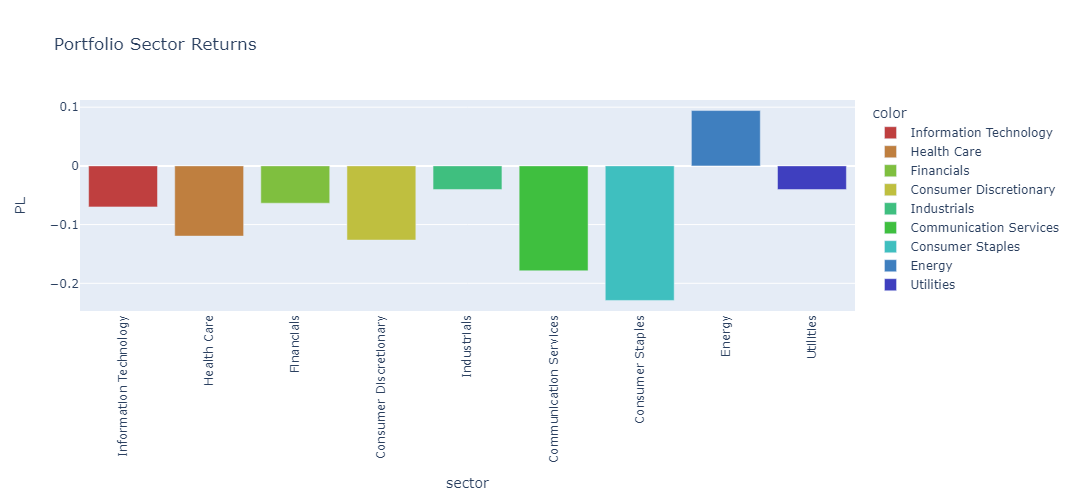

In [145]:
#Chart5

#Calculating the building blocks to create the portfolio P/L bar graph at the sector level.  
sectorstv = sectors.TV.sum().sort_values(ascending = False)
sectorsmv = sectors.MV.sum().sort_values(ascending = False)
sectorsdv  = sectorsmv - sectorstv

#Creating a dataframe from the building blocks. PL is the actual portfolio P/L. 
dv_frame = pd.DataFrame({'Sector': list(sectorsdv.index),
                         'Loss': sectorsdv.values,
                         'PL': sectorsdv/(sectorsmv + abs(sectorsdv))
                        }).set_index('Sector').reindex(sector_delta.index)

#Creating the bar graph of portfolio returns at the sector level. 
chart5 = px.bar(dv_frame, x = dv_frame.index, y = dv_frame['PL'], color =[x for x in dv_frame.index],
                color_discrete_map=colormap,
               title='Portfolio Sector Returns',
                height = 500)

#Tweaking the tick angles and changing the placement of the bars to match the SP500 sector indexes. 
chart5.update_xaxes(tickangle = -90)
chart5.update_layout(xaxis={'categoryorder':'array', 'categoryarray':[x for x in dv_frame.index if x in spy2.index]})

chart5.show()

### Making Portfolio Weight and return graphs with Plotly 

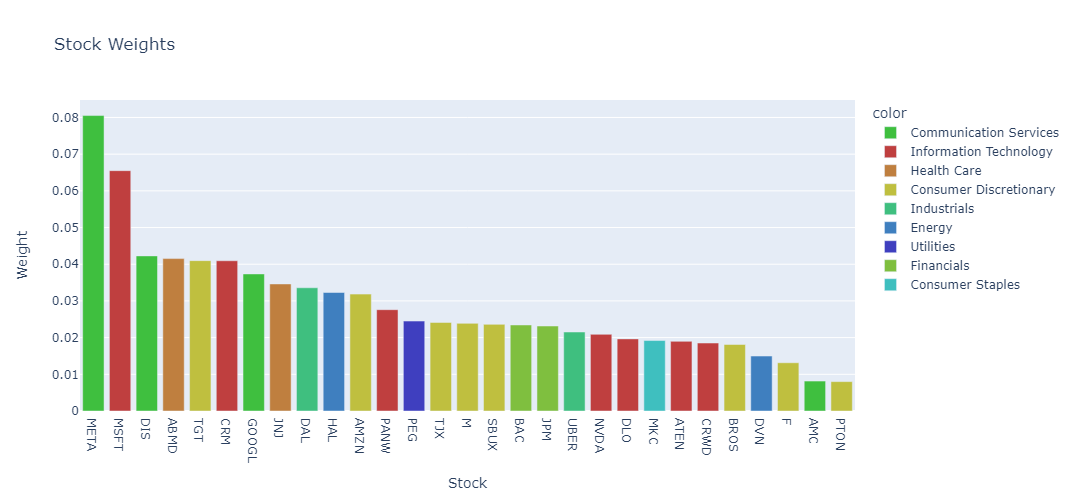

In [146]:
#Chart6

#Creating a dataframe of stock weights
stock_weights = pd.DataFrame({'Stock':stocks['Instrument'],
                              'Weight':[x/(stocks['MV'].sum() + ad) for x in stocks['MV']],
                              'Sector': stocks['Sector']
                             }).sort_values(by = 'Weight',ascending = False)

#Creating a bar graph of stock weights
chart6 = px.bar(stock_weights, x = 'Stock', y = 'Weight', color =[x for x in stock_weights['Sector']],
                color_discrete_map=colormap,
               title='Stock Weights',
                height = 500)

#Tweaking the placement of the bars to be displayed in descending order
chart6.update_layout(xaxis={'categoryorder':'array', 'categoryarray':stock_weights['Stock']})
chart6.show()

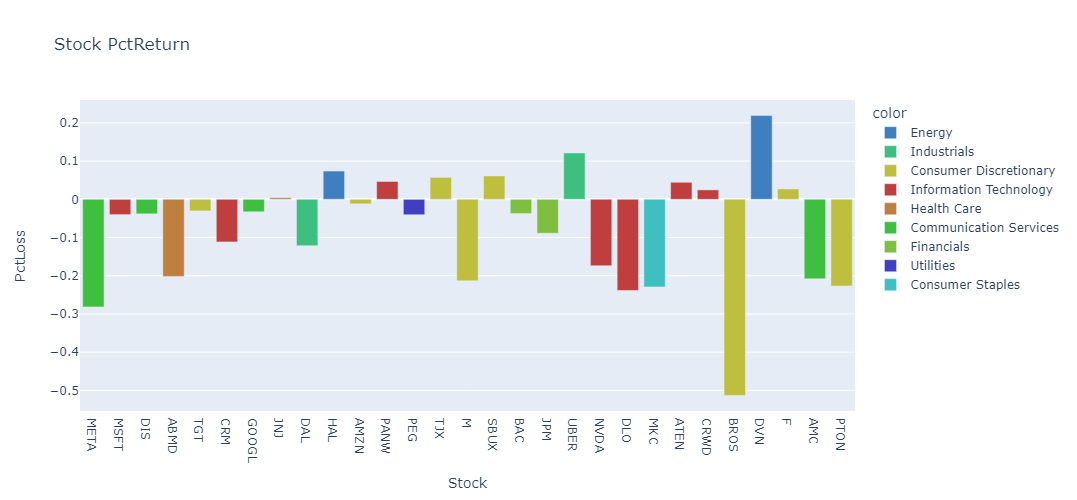

In [147]:
#Chart7

#Creating datafame of P/L (returns) by stock 
stock_pctreturn = pd.DataFrame({'Stock':stocks['Instrument'],
                              'PctLoss':(stocks['MV'] - stocks['TV'])/ stocks['TV'],
                              'Sector': stocks['Sector']
                             }).sort_values(by = 'PctLoss',ascending = False)

#Creating bar graph of P/L (returns) by stock
chart7 = px.bar(stock_pctreturn, x = 'Stock', y = 'PctLoss', color =[x for x in stock_pctreturn['Sector']],
                color_discrete_map=colormap,
               title='Stock PctReturn',
                height = 500)

#Tweaking the placement of the bars to be displayed in the order of the stock weights (descending order)
chart7.update_layout(xaxis={'categoryorder':'array', 'categoryarray':stock_weights['Stock']})
chart7.show()

### Creating a table for all essential single digit metrics


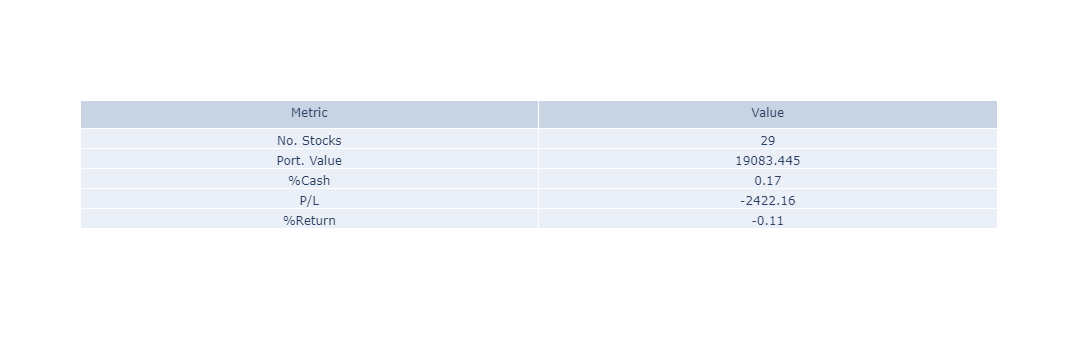

In [148]:
#Table1

#Creating a dataframe with the essential metrics
pss = pd.DataFrame([numstocks,
                    pv,
                    round(cashstock[0],2),
                    pl,
                    round(preturn,2)],
                   index = ['No. Stocks','Port. Value','%Cash','P/L','%Return'],
                   columns = ['Value'])

#Converting the dataframe into a go figure 
t1 = go.Figure(data = [go.Table(header = dict(values = ['Metric']+ pss.columns.tolist()),
                           cells = dict(values = [pss.index.tolist()] + pss.T.values.tolist())
                          )])

t1

### Creating a table for stock counts


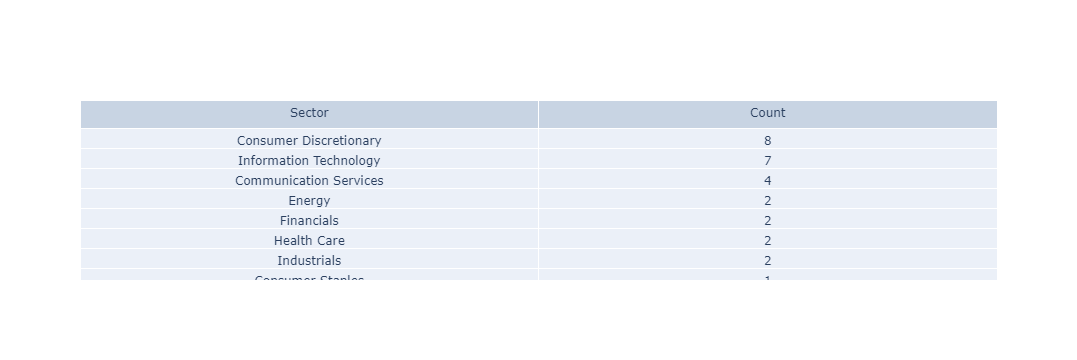

In [149]:
#Table2

#Creating a dataframe of stock counts and ordering in descending order
stock_counts = pd.DataFrame(stock_weights.groupby('Sector')['Stock'].count()).rename(columns = {'Stock':'Count'}).sort_values(by = 'Count',ascending = False)
stock_counts

#Converting the dataframe into a go figure 
t2 = go.Figure(data = [go.Table(header = dict(values = ['Sector'] + stock_counts.columns.tolist()),
                           cells = dict(values = [stock_counts.index.tolist()] + stock_counts.T.values.tolist())
                          )])

t2

## Combining Charts and Tables for the Dashboard

**1.** Combining **Chart4** and **Chart5** for sector level analysis <br>
&emsp; 1. This view answers the question "Am I overweigt/underweight on this sector compared to the SP500?" This is helpful to know because you may  <br> &emsp; &emsp; not want to be overweight in a market sector that isn't performing well (e.g., Technology sector at the time of writing). <br>
&emsp; 2. The sector level return view gives a macro view to portfolio performance. This is a good first step before drilling down into individual  <br> &emsp; &emsp; stocks (sneak peak: that is the next view).

**2.** Combining **Chart6** and **Chart7** for stock level analysis <br>
&emsp; 1. This view answers the questions "How much of my portfolio does this stock take up?" and "Is this stock making or losing me money?" These  <br> &emsp; &emsp; are important questions to answer because you may have portfolio exposure rules to individual names and sell rules. <br>
&emsp; 2. This view drills down into the invidiual stocks that comprise the sectors. You can see the portfolio weights and their returns. <br>

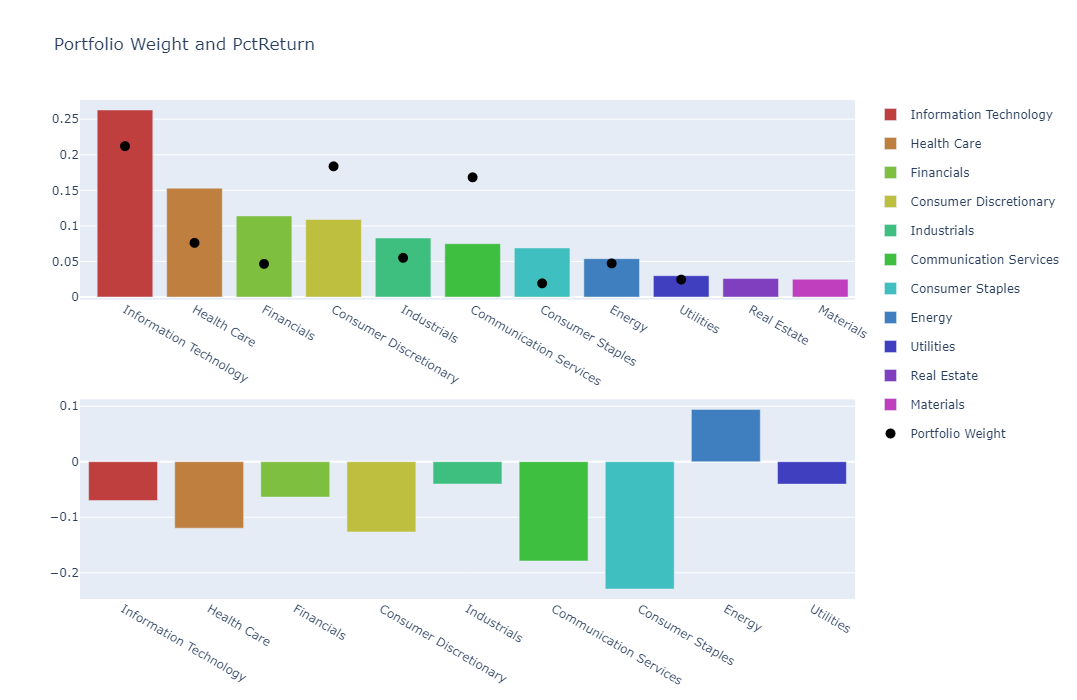

In [150]:
#Combining Chart5 and Chart6 

# For as many traces that exist per Express figure, get the traces from each plot and store them in an array (chart1_traces and chart2_traces).
# This is breaking down the Express fig into it's traces. 
chart1_traces = []
chart2_traces = []
for trace in range(len(chart4["data"])):
    chart1_traces.append(chart4["data"][trace])
for trace in range(len(chart5["data"])):
    chart2_traces.append(chart5["data"][trace])

#Create a 2x1 subplot
this_figure = sp.make_subplots(rows=2, cols=1,vertical_spacing = 0.20) 

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in chart1_traces:
    this_figure.append_trace(traces, row=1, col=1)
for traces in chart2_traces:
    this_figure.append_trace(traces, row=2, col=1)
    
#Adjusting the dimensions of the figure 
this_figure.update_layout(bargap=1,
                           width= 1000, 
                           height = 700,
                           title = 'Portfolio Weight and PctReturn')

#Fixing the width of the bars. This is done by looping through the trace data and adjusting the 'bar width' parameters. 
for i in range(len(this_figure['data'])):
    if type(this_figure['data'][i]) != plotly.graph_objs._bar.Bar: continue
    else: this_figure['data'][i].width = .8

#Removing the legend for graph 2. Loop through the trace data and identify the 'xaxis' parameter for the second figure. 
for i in range(len(this_figure['data'])):
    if this_figure['data'][i].xaxis == 'x2': this_figure['data'][i].showlegend = False
    else: continue

#Editing font sizes/orientation as an FYI
#this_figure.layout.xaxis.tickangle = 50
#this_figure.layout.xaxis2.tickangle = -90
#this_figure.layout.xaxis.tickfont = dict(size=10)
this_figure.show()

### Joining Portfolio Weight and Return Graphs Together

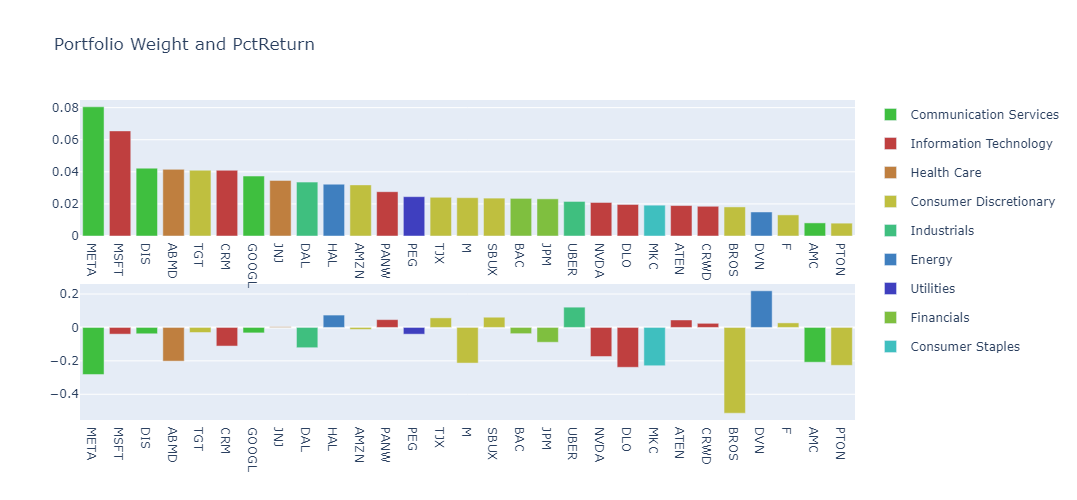

In [151]:
# For as many traces that exist per Express figure, get the traces from each plot and store them in an array.
# This is breaking down the Express fig into it's traces
chart3_traces = []
chart4_traces = []
for trace in range(len(chart6["data"])):
    chart3_traces.append(chart6["data"][trace])
for trace in range(len(chart7["data"])):
    chart4_traces.append(chart7["data"][trace])

#Create a 1x2 subplot
this_figure2 = sp.make_subplots(rows=2, cols=1) 

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in chart3_traces:
    this_figure2.append_trace(traces, row=1, col=1)
for traces in chart4_traces:
    this_figure2.append_trace(traces, row=2, col=1)
    

this_figure2.update_layout(xaxis={'categoryorder':'array', 'categoryarray':stock_weights['Stock']},
                          xaxis2={'categoryorder':'array', 'categoryarray':stock_weights['Stock']},
                          bargap=1,
                          width= 1000, 
                          height = 500,
                          title = 'Portfolio Weight and PctReturn')

#Fixing the width of the bars
for i in range(len(this_figure2['data'])):this_figure2['data'][i].width = .8

#Removing the legend for graph 2
for i in range(len(this_figure2['data'])):
    if this_figure2['data'][i].xaxis == 'x2': this_figure2['data'][i].showlegend = False
    else: continue


this_figure2.show()

## Creating the dashboard

&emsp; 1. Tab 1 adds summary statistics (table) to the sector level analysis <br>
&emsp; 2. Tab 2 adds stock counts (table) to the stock level analysis

In [152]:
#Tab1 

# Setup the style from the link: Not necessary to run this unless running the tab individually. Leaving as FYI 
#external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
# Embed the style to the dashabord: Not necessary to run this unless running the tab individually. Leaving as FYI 
#app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

#Turning the combined graph and table into dcc objects
graph1 = dcc.Graph(
        id='graph1',
        figure=this_figure,
        className="eight columns" 
    )

table1 = dcc.Graph(
        id='table1',
        figure=t1,
        className="four columns" 
    )

# setup the header
header = html.H2(children="Portfolio Sector Metrics and SPY Comparison")

# setup the rows 
row1t1 = html.Div(children=[table1,graph1])

# setup & apply the layout. Not necessary to run this unless running the tab individually. Leaving as FYI 
# layout = html.Div(children=[header, row1t1], style={"text-align": "center"})
# app.layout = layout

### Create the dashboard (for tab 2) 

In [153]:
#Tab 2 

# Setup the style from the link: Not necessary to run this unless running the tab individually. Leaving as FYI 
#external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
# Embed the style to the dashabord: Not necessary to run this unless running the tab individually. Leaving as FYI 
#app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

graph2 = dcc.Graph(
        id='graph2',
        figure=this_figure2,
        className="eight columns" 
    )

## Sneaky insert of the table t1
table2 = dcc.Graph(
        id='table2',
        figure=t2,
        className="four columns" 
    )

# setup the header
header2 = html.H2(children="Stock Level Performance")

# setup the rows
row1t2 = html.Div(children=[graph2,table2])

# setup & apply the layout. Not necessary to run this unless running the tab individually. Leaving as FYI 
# layout = html.Div(children=[header2, row1t2], style={"text-align": "center"})
# app.layout = layout

### Creating the dashboard with tabs

In [154]:
# Setup the style from the link:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
# Embed the style to the dashabord:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    dcc.Tabs([
        dcc.Tab(label='Tab one', children=[header, row1t1], style={"text-align": "center"}),
        dcc.Tab(label='Tab two', children=[header2, row1t2], style={"text-align": "center"}),
    ])
])

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_6_0m1658940669.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET /_dash-component-suites/dash/deps/react@16.v2_6_0m1658940669.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_6_0m1658940669.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_6_0m1658940669.8.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_6_0m1658940669.min.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_6_0m1658940669.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 13:49:42] "GET /_dash-component-suites/da